<a href="https://colab.research.google.com/github/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_04/Desafio/Desafio_04_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio - IGTI - Modulo 04 - Flowers Photo
- Autor: Rodrigo de Lima Oliveira
- Data : 25/06/2020
- LinkedIn: https://www.linkedin.com/in/rodrigolima82/

## Descrição do Problema

O objetivo desse desafio é classificar imagens pelo uso do Deep Learning (Keras e Tensorflow). Dessa vez iremos utilizar dados de imagens de flores para ensinar à rede as novas classes que precisará reconhecer. Vamos usar um arquivo de fotos de flores licenciadas da creative-commons do Google. O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.

Você precisará trabalhar nas seguintes etapas:

- Explorar os dados.
- Pré-processar os dados.
- Construir o modelo.
- Montar as camadas.
- Compilar o modelo.
- Treinar o modelo.
- Avaliar a acurácia.
- Fazer predições.

Ao final, o modelo estará treinado para reconhecer imagens de flores conforme as classes abaixo:

![title](https://github.com/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_04/Desafio/flowers.png?raw=1)


## Carregando as bibliotecas

In [1]:
!pip install -q efficientnet

In [2]:
# Imports de avisos
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulacao de dados e calculos matematicos
import os
import pandas as pd
import numpy as np
import math, re, time

# Import para manipulação das imagens
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as display
from PIL import Image
from skimage.transform import resize
import cv2

# Imports de bibliotecas para treinamento de redes neurais

from sklearn.model_selection import train_test_split
import tensorflow as tf
import efficientnet.tfkeras as efn

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop


from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE


Tensorflow version 2.2.0


In [3]:
# Verifica qual o harware está usando (TPU, GPU ou CPU)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
!pip install -q watermark
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Desafio - Modulo 04 - Rodrigo" --iversions

tensorflow 2.2.0
pandas     1.0.5
numpy      1.18.5
cv2.cv2    4.1.2
matplotlib 3.2.2
re         2.2.1
PIL.Image  7.0.0
Desafio - Modulo 04 - Rodrigo


## Carregando dataset de imagens de Flores

In [5]:
# Importando o dataset do storage do google
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# Verificando quantas imagens tem nos diretórios
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Quantidade de Imagens: ', image_count)

# Verificando todas as classes de flores (licenciadas)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENCE.txt"])

# Removendo o item que não é uma classe
CLASS_NAMES = np.delete(CLASS_NAMES, [5])

# Print das categorias de flores
print('Classes: ', CLASS_NAMES)

# Visualizando o tamanho de cada classe
fnames = []
for classes in CLASS_NAMES:
    flower_folder = os.path.join(data_dir, classes)
    file_names    = os.listdir(flower_folder)
    full_path     = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('Tamanho de cada classe de flor:', [len(f) for f in fnames])    

Quantidade de Imagens:  3670
Classes:  ['tulips' 'sunflowers' 'dandelion' 'roses' 'daisy']
Tamanho de cada classe de flor: [799, 699, 898, 641, 633]


Observações sobre o Dataset
- Este dataset contém 3.670 imagens de flores;
- As imagens estão divididas em 5 classes: *tulips, sunflowers, dandelion, roses and daisy;*
- Para cada classe existem entre 633 e 898 imagens;
- As fotos não estão no mesmo padrão de resolução.

## Visualização dos Dados

In [6]:
tulips     = list(data_dir.glob('tulips/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
dandelion  = list(data_dir.glob('dandelion/*'))
roses      = list(data_dir.glob('roses/*'))
daisy      = list(data_dir.glob('daisy/*'))

(500, 333)


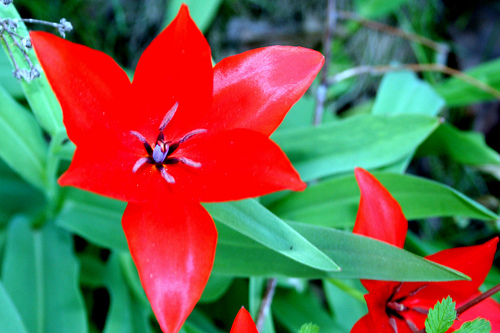

(168, 240)


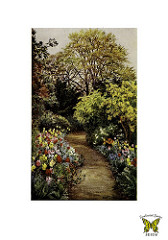

(320, 213)


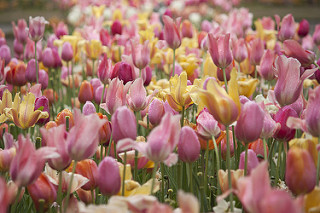

In [7]:
# Visualizando fotos de TULIPAS
for image_path in tulips[:3]:
  print(Image.open(str(image_path)).size)
  display.display(Image.open(str(image_path)))

(500, 375)


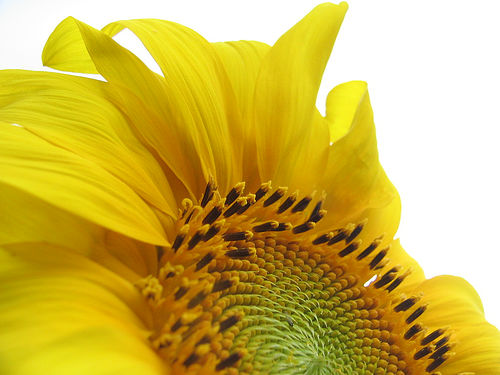

(320, 240)


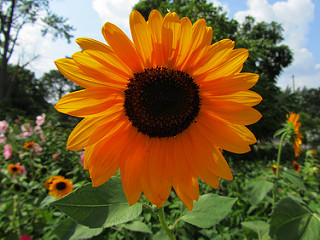

(320, 240)


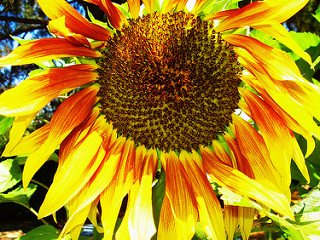

In [8]:
# Visualizando fotos de GIRASOL
for image_path in sunflowers[:3]:
  print(Image.open(str(image_path)).size)
  display.display(Image.open(str(image_path)))

## Preparação dos Dados

- Redimensionar todas as imagens para um size específico (no caso 256 x 256)
- Separar 80% de amostras para treinamento e 20% para validação
- Converter em formato numpy Keras

In [9]:
# Carregando as imagens das fotos usando CV2
images = []
for names in fnames:
    one_class_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_class_images)

In [10]:
# Verificando qual o melhor shape para o redimensionamento de todas as fotos
for i,imgs in enumerate(images):
    shapes  = [img.shape for img in imgs]
    widths  = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d é o menor shape para %s' % (np.min(widths), np.min(heights), CLASS_NAMES[i]))

159,143 é o menor shape para tulips
180,152 é o menor shape para sunflowers
211,146 é o menor shape para dandelion
200,159 é o menor shape para roses
180,158 é o menor shape para daisy


In [11]:
# Função para converter as imagens para formato RGB
def convert_to_RGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

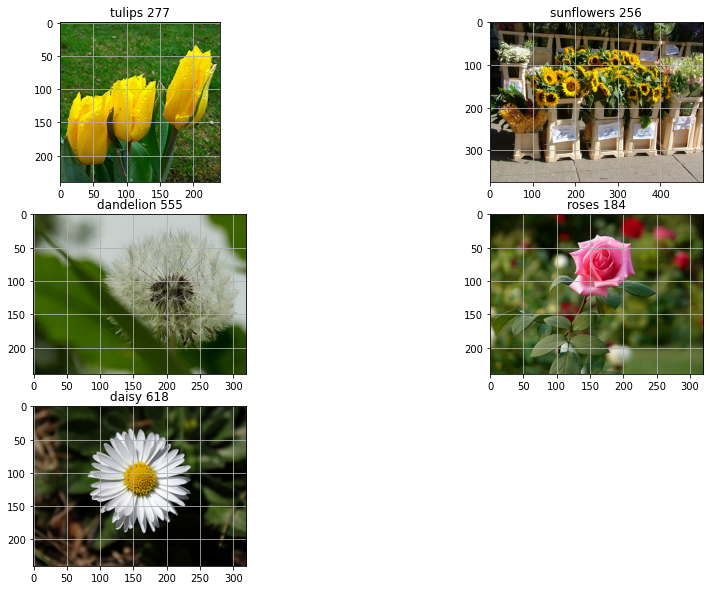

In [12]:
# Exibindo alguns exemplos das imagens convertidas para RGB
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(3,2,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(convert_to_RGB(imgs[idx]))
    plt.grid('off')
    plt.title(CLASS_NAMES[i]+' '+str(idx))
plt.show()

Shape Original:  (213, 320, 3)
Shape Alterado:  (256, 256, 3)


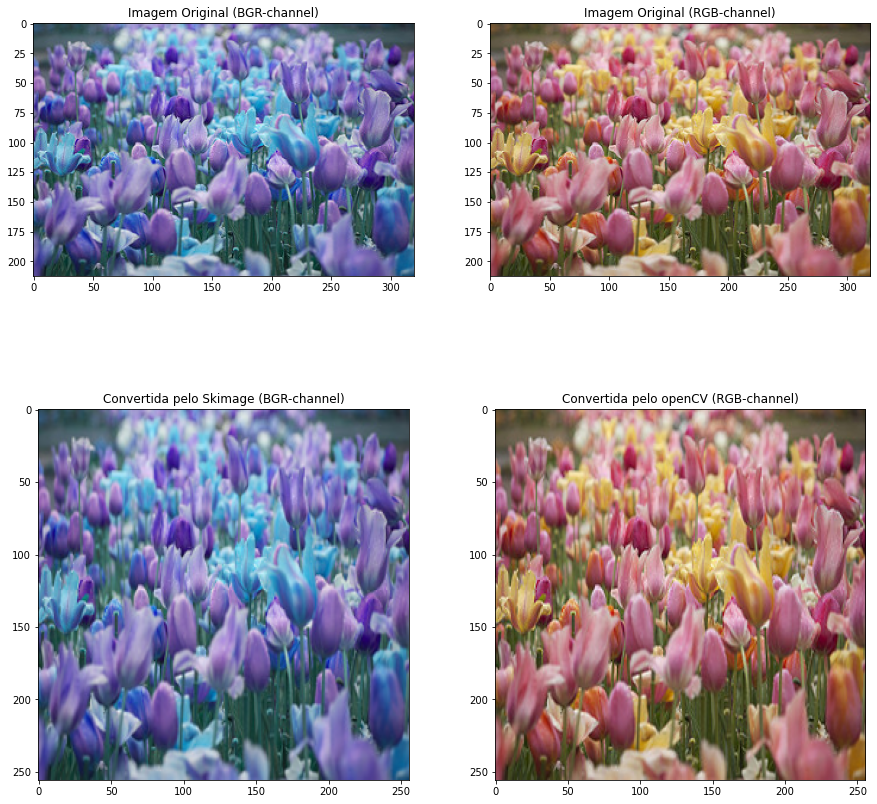

In [13]:
# Redimensionar todas as imagens para 256 x 256

# Definindo o tamanho do shape
img_width, img_height = 256, 256

# Pegando duas imagens de exemplo
img = images[0][2]

# Exibindo o shape original
print('Shape Original: ', img.shape)

# Redimensionando utilizando o skimage
resized_img = resize(img, (img_width, img_height, 3))
print('Shape Alterado: ', resized_img.shape)

# Redimensionando utilizando o openCV
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('Imagem Original (BGR-channel)')
plt.grid(False)
plt.imshow(img)

plt.subplot(2,2,2)
plt.title('Imagem Original (RGB-channel)')
plt.grid(False)
plt.imshow(convert_to_RGB(img))

plt.subplot(2,2,3)
plt.title('Convertida pelo Skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))

plt.subplot(2,2,4)
plt.title('Convertida pelo openCV (RGB-channel)')
plt.grid(False)
plt.imshow(convert_to_RGB(resized_img2))
plt.show()

In [14]:
# Redimensionando TODAS as imagens com o openCV
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [15]:
## Realizando o split dos dados para treinamento e validação (80/20)

# Criando as listas vazias
train_images = []
val_images   = []

# Loop percorrendo todaas as imagens redimensionadas e preenchendo as listas de treino e validação
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [16]:
## Criando os labels para as imagens de treinamento

# Exibindo a quantidade de dados para treinamento e a distribuição de cada classe
len_train_images = [len(imgs) for imgs in train_images]
print('Total para cada classe: ', len_train_images)
print('Total de imagens para treinamento:', np.sum(len_train_images))  

# Criando os labels de treinamento
train_classe = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_classe[:len_train_images[i]] = i
    else:
        train_classe[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Total para cada classe:  [639, 559, 718, 512, 506]
Total de imagens para treinamento: 2934


In [17]:
## Criando os labels para as imagens de validação

# Exibindo a quantidade de dados para validação e a distribuição de cada classe
len_val_images = [len(imgs) for imgs in val_images]
print('Total para cada classe: ', len_val_images)
print('Total de imagens para validação:', np.sum(len_val_images))  

# Criando os labels de validação
val_classe = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_classe[:len_val_images[i]] = i
    else:
        val_classe[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Total para cada classe:  [160, 140, 180, 129, 127]
Total de imagens para validação: 736


In [18]:
## Convertendo as imagens em formato array do numpy para submeter ao treinamento

# Criando listas temporarias
tmp_train_imgs = []
tmp_val_imgs   = []

# Percorrendo o dataset de treinamento e adicionando na lista temporaria
for imgs in train_images:
    tmp_train_imgs += imgs

# Percorrendo o dataset de validação e adicionando na lista temporaria
for imgs in val_images:
    tmp_val_imgs += imgs

# Convertendo em formato array
train_images_np = np.array(tmp_train_imgs)
val_images_np   = np.array(tmp_val_imgs)

# Removendo listas temporarias
del tmp_train_imgs, tmp_val_imgs

In [19]:
print('*** Antes de converter***')
print('train data:', train_images_np.shape)
print('train labels:', train_classe.shape)

# Transformando os dados para o tipo float32
train_data   = train_images_np.astype('float32')
val_data     = val_images_np.astype('float32')

# Converter o array de labels para cada classe em vetores one-hot 
train_labels = np_utils.to_categorical(train_classe, len(CLASS_NAMES))
val_labels   = np_utils.to_categorical(val_classe, len(CLASS_NAMES))

print('\n*** Depois de converter ***')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

*** Antes de converter***
train data: (2934, 256, 256, 3)
train labels: (2934,)

*** Depois de converter ***
train data: (2934, 256, 256, 3)
train labels: (2934, 5)


## Modelos 


- Neste desafio, estarei aplicando 3 arquitetura de redes neurais:

  - O primeiro modelo é uma rede neural convolucional com 3 camadas ocultas, sendo uma estrutura de 32, 64 e 128 neuronios.

In [23]:
# Definindo os parametros gerais para treinamento
batch_size = 32
epochs     = 10

In [24]:
# Função para criar a estrutura de nosso modelo CNN
def create_model_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(CLASS_NAMES)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [25]:
# Criando o objeto de rede neural convolucional e exibindo o resumo
model_cnn = create_model_cnn()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)       

### Data Augmentation

In [26]:
## Aplicando data augmentation para melhorar a performance do modelo

# Para dataset de treinamento
train_datagen = ImageDataGenerator(rescale            = 1./255,
                                   rotation_range     = 40,
                                   width_shift_range  = 0.4,
                                   height_shift_range = 0.4,
                                   shear_range        = 0.2,
                                   zoom_range         = 0.3,
                                   horizontal_flip    = True)

# Para dataset de validação (apenas rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Fluxo em batch 32 usando train_datagen
train_generator = train_datagen.flow(train_data,
                                     train_labels,
                                     batch_size=batch_size)

val_generator = val_datagen.flow(val_data,
                                 val_labels,
                                 batch_size=batch_size)

### Treinamento do modelo

In [ ]:
# Marcando o tempo de início
start = time.time()

# Treinamento do modelo
# Realizando o treinamento do modelo CNN
model = model_cnn.fit_generator(generator        = train_generator, 
                                steps_per_epoch  = len(train_data)/batch_size,
                                epochs           = epochs, 
                                validation_steps = len(val_data)/batch_size,
                                validation_data  = val_generator, 
                                verbose          = 2)

# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Duração %0.2f seconds (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

Epoch 1/10


### Validação do Modelo

In [ ]:
# Função para exibir o desempenho do modelo em treino e teste
def plot_model(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

In [ ]:
# Exibindo o desempenho do modelo
plot_model('Modelo CNN', model.history, epochs)

### Realizando previsões

In [ ]:
# Função para realizar previsão da classe das imagens passadas como parâmetro
def predict_image(image, model):
  image = cv2.resize(image, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  image = np.reshape(image, (1, img_width, img_height, 3))
  image = image/255.
  pred  = model.predict(image)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
# Realizando algumas previsões
for i, imgs in enumerate(images):
    plt.subplot(3,2,i+1)
    idx = np.random.randint(len(imgs))
    
    test_img = imgs[idx]
    pred, probability = predict_image(test_img, model)
    print('%s %d%%' % (CLASS_NAMES[pred], round(probability, 2) * 100))

    _, ax = plt.subplots(1)
    plt.imshow(convert_to_RGB(test_img))

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid('off')
    plt.show()
